# Tutorials #1: Environments Descriptions

This tutorial briefly explains how we define environments for planetary rover navigation problems. What we would like to express here is rovers need to plan safe motion in **traversability maps** considering wheel slip behavior on deformable terrains. 

In [1]:
# Import the necessary libraries

# Add the parent directory to the path so that the environment can be found
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

# Import the necessary libraries
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Import the necessary classes
from environments.grid_map import GridMap
from environments.terrain_properties import TerrainGeometry
from environments.terrain_properties import TerrainColoring
from environments.terrain_properties import TerrainTraversability

sns.set()

device = "cuda" if torch.cuda.is_available() else "cpu"

## Grid map generation

The goal of this notebook is to explain environment definitions in this repository. The map to be used for motion planning is represented as discrete grid map defined as `GridMap` class. We can easily set geometry and apperance information into the map using `TerrainGeometry` and `TerrainColoring` classes.

1. Initialize `GridMap` with the prefereble size of grid `grid_size` and grid resolution [m] `resolution`. You can also provide `seed` if you want to maintain reproductivity.

In [2]:
grid_map = GridMap(
    grid_size=64,  # 64x64 grid
    resolution=0.5,  # 0.5m per grid
    seed=0,  # random seed
    device=device,  # device    
)

2. Call `TerrainGeometry` in order to set geometrical information into the grid map. If you want to create just a random height environment, you can set `is_fractal = True` and `is_crater = False` . If you want to create an environment having crater-like geometry, you can set `is_crater = True`. In order to generate crater, you can tune the number of craters as well as those characteristics, such as the size and slope magnitude. However, if the parameters do not fit the grid map, the crater generation procedure ends in the middle.

In [3]:
terrain_geometry = TerrainGeometry(grid_map=grid_map)
terrain_geometry.set_terrain_geometry(
    is_fractal=True,  # fractal terrain
    is_crater=True,  # with crater
)

3. Call `TerrainColoring` in order to set appearance inoformation into the grid map. What you need to create color map is `occupancy` defining occupancy ratios for different terrain classes.

In [4]:
occupancy = torch.tensor([0.4, 0.4, 0.1, 0.1])  # 40% of #0, 40% of #1, 10% of #2, 10% of #3 terrain classes

terrain_coloring = TerrainColoring(grid_map=grid_map)
terrain_coloring.set_terrain_class_coloring(
    occupancy=occupancy
)

That is it! You have now created a grid map with fractal terrain and colored it with the specified terrain classes.
More specifically, you can access `tensor_data` attribute in `GridMap` class and it contains the following information.
- heigths: A 2D tensor representing the terrain height map in [m].
- slopes: A 2D tensor representing the terrain slope values in [deg].
- colors: A 3D tensor (3 x height x width) representing RGB color values.
- t_classes: A 2D tensor representing terrain classes for every pixel.

### Visualized examples of terrain geometry

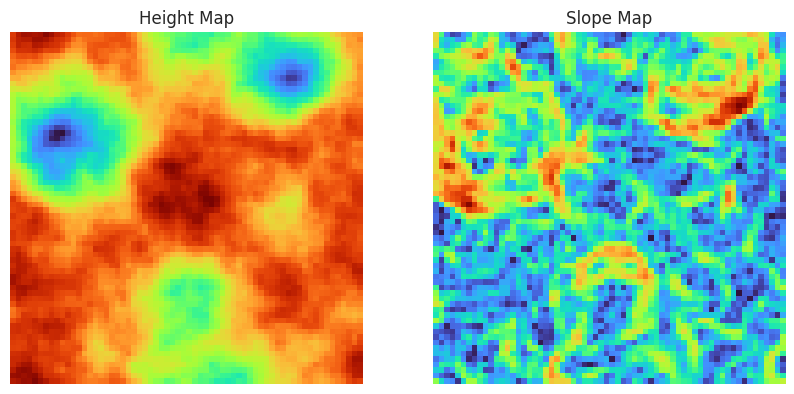

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# height map
axs[0].imshow(grid_map.tensor_data["heights"].cpu().numpy(), cmap="turbo")
axs[0].set_title("Height Map")
axs[0].axis("off")

# slope map
axs[1].imshow(grid_map.tensor_data["slopes"].cpu().numpy(), cmap="turbo")
axs[1].set_title("Slope Map")
axs[1].axis("off")

plt.show()

## Visualized examples of terrain coloring

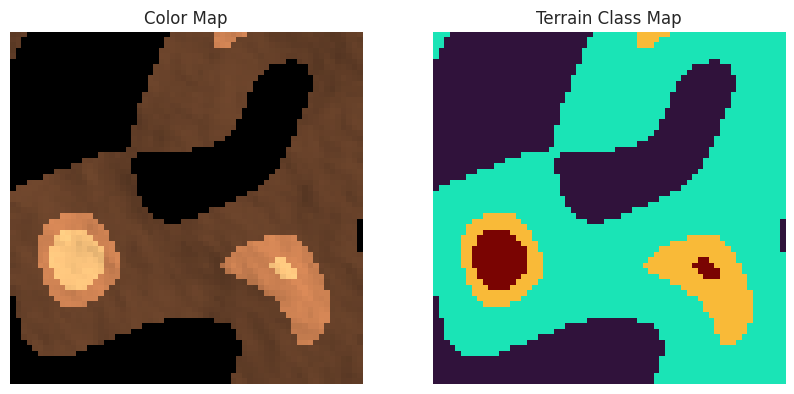

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# height map
axs[0].imshow(grid_map.tensor_data["colors"].cpu().numpy().transpose(1, 2, 0))
axs[0].set_title("Color Map")
axs[0].axis("off")

# slope map
axs[1].imshow(grid_map.tensor_data["t_classes"].cpu().numpy(), cmap="turbo")
axs[1].set_title("Terrain Class Map")
axs[1].axis("off")

plt.show()

## Slip Model Generation
Now you can see the environment represented as `GridMap` has diverse geometry and appearance inforamtion. We further assign latent slip models for each terrain classes. The assumption is as follows:
- Each terrain class has a single latent slip model.
- Slip model takes slope [deg] input and outputs slip ratio $s$ ($-1 < s < 1$). If $|s| \geq 1$, the robot cannot move any more (permanent robot entrapment).

Based on the above settings, we define the `SlipModel` class to project terrain geometry into traversability for assigned terrain classes.

In [7]:
from src.environments.slip_model import SlipModel

1. Initialize `SlipModel`. You can provide hyper-parameters for the latent slip models in order tune its steepness.

In [8]:
model = SlipModel(
    slip_sensitivity=1.0,  # sensitivity of slip to slope
    slip_nonlinearity=2.0,  # nonlinearity of slip to slope
    slip_offset=0.1,  # offset of slip at zero slope
    base_noise_scale=0.1,  # noise scales
    device=device,
)

2. Model probability distribution of slip for the given slope angles.

In [9]:
phis = torch.linspace(0, 30, 500).to(device)  # slope angles from 0 to 30 degrees
slip_dist = model.model_distribution(phis)  # slip distribution for the given slope angles

3. You can then sample observations from the actual slip distribution.

In [10]:
slips = slip_dist.sample()  # sample slip values for each slope angle

That is it! You can see how the slip changes with the slope angle.

## Visualized examples of latent slip models

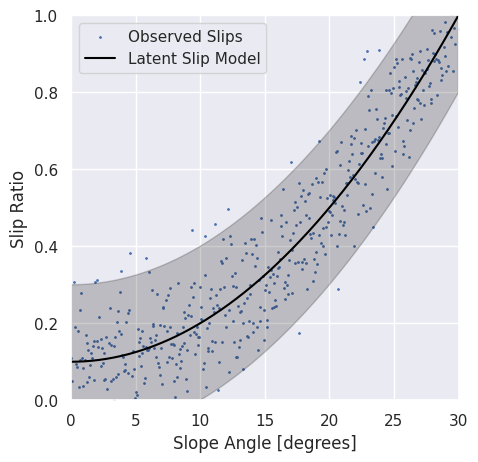

In [11]:
# retrieve noise-free slip model
mean_slip = slip_dist.mean
# retrieve noise scales for the given slope angles
std_slip = slip_dist.stddev
lowers = mean_slip - 2 * std_slip  # lower bounds
uppers = mean_slip + 2 * std_slip  # upper bounds

# plot slip model
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(phis.cpu().numpy(), slips.cpu().numpy(), s=1, label="Observed Slips")
ax.plot(
    phis.cpu().numpy(),
    mean_slip.cpu().numpy(),
    label="Latent Slip Model",
    color="black",
)
ax.fill_between(
    phis.cpu().numpy(),
    lowers.cpu().numpy(),
    uppers.cpu().numpy(),
    alpha=0.2,
    color="black",
)
ax.set_xlabel("Slope Angle [degrees]")
ax.set_ylabel("Slip Ratio")
ax.set_xlim(0, 30)
ax.set_ylim(0, 1)
ax.grid(True)
ax.legend()

plt.show()

# Terrain Traversability Generation

Now we have terrain geometry and coloring information as well as assigned slip models in each terrain class. How we can obtain terrain traversabilty map? We finally explain how to generate terrain traversability map that is used for navigation procedures.

1. Define slip models for terrain classes. According to the `occupancy`, we have four distinct terrain classes so the slip models should be set for each terrain class. We provide `SlipModelsGenerator` that automatically generates distinct slip models for each terrain class. It returns the dictionary of `SlipModel`.

In [12]:
from src.data.slip_models_generator import SlipModelsGenerator

In [13]:
slip_models_generator = SlipModelsGenerator(
    num_total_terrain_classes=occupancy.size()[0],  # number of terrain classes
    slip_sensitivity_minmax=(1.0, 9.0),  # sensitivity of slip to slope
    slip_nonlinearity_minmax=(1.4, 2.0),  # nonlinearity of slip to slope
    slip_offset_minmax=(0.0, 0.1),  # offset of slip at zero slope
    noise_scale_minmax=(0.1, 0.2),  # noise scales
    device=device,
)

slip_models = slip_models_generator.generate_slip_models()

2. Call `TerrainTraversability` in order to generate traversability map based on terrain appearance (class inforamtion) and geometry (slope information). You just need to set slip models in `set_traversability` and it generates slip as probability distribution. 

In [14]:
terrain_traversability = TerrainTraversability(grid_map=grid_map)
terrain_traversability.set_traversability(
    slip_models=slip_models
)

That is it! You can obtain actual slip distributions by calling `tensor_data["slips"]` from `GridMap` class. Note that the distributions is based on `torch.distributions.Normal` so you need to call its `mean` and `stddev`.

## Visualized examples of terrain traversability map

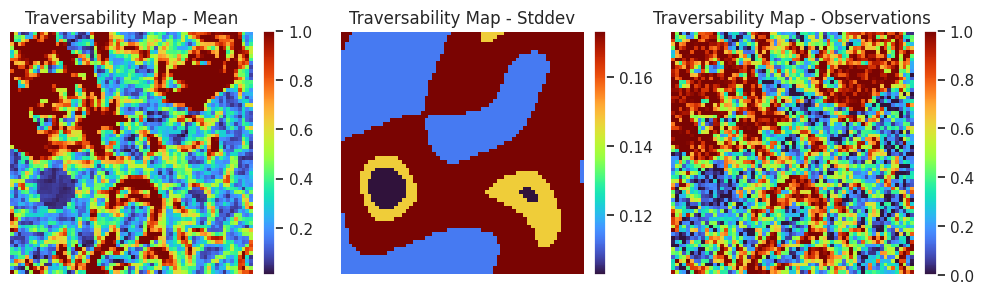

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Prepare mean and stddev maps
slips = grid_map.tensor_data["slips"]
mean_slips = slips.mean.cpu().numpy()
stddev_slips = slips.stddev.cpu().numpy()
# Prepare observations map (clamped to [0, 1])
observations = torch.clamp(slips.sample(), 0, 1)
observations = observations.cpu().numpy()

# mean map
mean_img = axs[0].imshow(mean_slips, cmap="turbo")
axs[0].set_title("Traversability Map - Mean")
axs[0].axis("off")
fig.colorbar(mean_img, ax=axs[0], orientation="vertical", fraction=0.046, pad=0.04)

# stddev map
stddev_img = axs[1].imshow(stddev_slips, cmap="turbo")
axs[1].set_title("Traversability Map - Stddev")
axs[1].axis("off")
fig.colorbar(stddev_img, ax=axs[1], orientation="vertical", fraction=0.046, pad=0.04)

# observations map
obs_img = axs[2].imshow(observations, cmap="turbo")
axs[2].set_title("Traversability Map - Observations")
axs[2].axis("off")
fig.colorbar(obs_img, ax=axs[2], orientation="vertical", fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()